In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class Riverswim:
    def __init__(self, states_count, actions_count=2, gamma=0.95):
        self.states_count = states_count
        self.actions_count = actions_count
        self.P = np.zeros((states_count, actions_count, states_count))
        self.R = np.zeros((states_count, actions_count))
        self.gamma = gamma  # Discount factor
        self.terminal_state = states_count - 1  # Define the rightmost state as terminal

        for s in range(states_count):
            if s == 0:
                self.P[s, 0, s] = 1  
                self.P[s, 1, s] = 0.6  
                self.P[s, 1, s + 1] = 0.4  
                self.R[s, 0] = 0.05
            elif s == self.terminal_state:
                self.P[s, 0, s] = 1 
                self.P[s, 1, s] = 1  
            else:
                self.P[s, 0, s - 1] = 1 
                self.P[s, 1, s] = 0.55  
                self.P[s, 1, s + 1] = 0.4 
                self.P[s, 1, s - 1] = 0.05  
        
        # Moving into RL state by right action
        self.R[states_count - 2, 1] = 1
        self.s = 0  # Start state

    def reset(self):
        self.s = 0
        return self.s

    def step(self, action):
        # In the terminal state, do not move; else, proceed as usual
        if self.s == self.terminal_state:
            return self.s, 0  # Assuming 0 reward for terminal state
        
        new_s = np.random.choice(np.arange(self.states_count), p=self.P[self.s, action])
        reward = self.R[self.s, action]
        self.s = new_s
        return new_s, reward
    
    def policy_always_right(self, num_states):
        """ Always go right until the final state and stay there"""
        P = np.full((num_states, 2), (0, 1))
        
        return P
    
    def policy_b(self, num_states):
        """ Always go right until the final state and stay there"""
        P = np.full((num_states, 2), (0.35, 0.65))
        
        return P
    
    def policy_matrix(self, policy):
        # Create a policy matrix that represents the transition probabilities under the given policy.
        policy_mat = np.zeros((self.states_count, self.states_count))
        for s in range(self.states_count):
            policy_prob = policy[s]
            # Calculate the expected transition probability for each state under the given policy
            policy_mat[s] = policy_prob[0] * self.P[s, 0] + policy_prob[1] * self.P[s, 1]
        return policy_mat

    def reward_vector(self, policy):
        # Create a reward vector that represents the expected immediate reward from each state under the given policy.
        reward_vec = np.zeros(self.states_count)
        for s in range(self.states_count):
            policy_prob = policy[s]
            # Calculate the expected immediate reward for each state under the given policy
            reward_vec[s] = policy_prob[0] * self.R[s, 0] + policy_prob[1] * self.R[s, 1]
        return reward_vec
    
    def value_true(self, gamma, policy):
        p = self.policy_matrix(policy)
        r = self.reward_vector(policy=policy) 
        i = np.eye(6)
        return np.linalg.inv(i - gamma * p) @ r
    
    def per_decision_importance_sampling_estimator(self, trajectories, pi, pi_b, gamma):
        total_rho_return = 0   
        history = [] 
        for t, trajectory in enumerate(trajectories):
            rho_t = 1
            reward_t = 0
            discount = 1
            for _, step in trajectory.iterrows():
                state, action, reward, _ = step # Extracting state, action, reward, and next state
                state, action = int(state), int(action)  
                
                # Only calculate rho_t if the state is not the terminal state
                if state != self.terminal_state:
                    rho_t *= pi[state, action] / pi_b[state, action]
                
                # Calculate the discounted return
                reward_t += discount * reward
                discount *= gamma
                
                # Update the total importance weighted return
                total_rho_return += rho_t * reward_t
                history.append(total_rho_return / (t+1))

        # Normalize the total return by n (number trajectories) to get the IS estimate
        is_estimate = total_rho_return / len(trajectories)
        return is_estimate, history
    
    def importance_sampling_estimator(self, trajectories, pi, pi_b, gamma):
        total_rho_return = 0   
        history = [] 
        for t, trajectory in enumerate(trajectories):
            rho_t = 1
            reward_t = 0
            discount = 1
            for _, step in trajectory.iterrows():
                state, action, reward, _ = step # Extracting state, action, reward, and next state
                state, action = int(state), int(action)  
                
                # Only calculate rho_t if the state is not the terminal state
                if state != self.terminal_state:
                    rho_t *= pi[state, action] / pi_b[state, action]
                
                # Calculate the discounted return
                reward_t += discount * reward
                discount *= gamma
                
                history.append(total_rho_return / (t+1))
                
            # Update the total importance weighted return
            total_rho_return += rho_t * reward_t

        # Normalize the total return by n (number trajectories) to get the IS estimate
        is_estimate = total_rho_return / len(trajectories)
        return is_estimate, history

    def weighted_importance_sampling_estimator(self, trajectories, pi, pi_b, gamma):
        total_rho_return = 0
        total_rho = 0
        history = []
        for trajectory in trajectories:
            rho_t = 1  # Importance sampling ratio for the current trajectory
            reward_t = 0  # Total return for the current trajectory
            discount = 1  # Discount factor
            
            for t, step in trajectory.iterrows():
                state, action, reward, _ = step # Extracting state, action, reward, and next state
                state, action = int(state), int(action)  
                
                # Calculate rho_t for non-terminal states
                if state != self.terminal_state:
                    rho_t *= pi[state, action] / pi_b[state, action]
                
                # Calculate the discounted return
                reward_t += discount * reward
                discount *= gamma
                
                history.append(total_rho_return / total_rho if total_rho != 0 else 0)
            
            # Update the total weighted return and total weight
            total_rho_return += rho_t * reward_t
            total_rho += rho_t
        
        # Calculate the weighted importance sampling estimate
        wis_estimate = total_rho_return / total_rho if total_rho != 0 else 0
        return wis_estimate, history
    
    def mb_ope(self, data, gamma, alpha, pi):
        # Initialize model components
        N_sa = np.zeros((self.states_count, self.actions_count))
        N_ss_a = np.zeros((self.states_count, self.actions_count, self.states_count))
        rewards = np.zeros((self.states_count, self.actions_count))

        # Initialize estimated model matrices
        P_hat = np.zeros((self.states_count, self.actions_count, self.states_count))
        r_hat = np.zeros((self.states_count, self.actions_count))

        V_history = []  # Track history of value function estimates

        for _, row in data.iterrows():
            state, action, reward, next_state = row 
            state, next_state, action = int(state), int(next_state), int(action)  
            
            if state == self.terminal_state:
                N_sa[state, abs(action-1)] += 1
                N_ss_a[state, abs(action-1), next_state] += 1
                rewards[state, abs(action-1)] += reward
            
            N_sa[state, action] += 1
            N_ss_a[state, action, next_state] += 1
            rewards[state, action] += reward

            # Update estimated model with current data
            for state in range(self.states_count):
                P_hat[state, action] = (N_ss_a[state, action] + alpha) / (N_sa[state, action] + alpha * self.states_count)
            
            r_hat = (rewards + alpha) / (N_sa + alpha)

            P_hat_pi = np.zeros((self.states_count, self.states_count))
            r_hat_pi = np.zeros(self.states_count)
            # Update value function estimate using the updated model
            for state in range(self.states_count):
                for action in range(self.actions_count):
                    P_hat_pi[state] += pi[state, action] * P_hat[state, action]
                    r_hat_pi[state] += pi[state, action] * r_hat[state, action]
            
            V = np.linalg.inv(np.eye(self.states_count) - gamma * P_hat_pi) @ r_hat_pi
            V_history.append(V.copy())  # Save the updated value function estimate

        return V, V_history

def split_into_trajectories(df):
    trajectories = []
    current_trajectory = []
    
    for index, row in df.iterrows():
        # Include the current row in the trajectory
        current_trajectory.append(row)
        # If the next_state is 5, we end the current trajectory and start a new one
        if int(row['state']) == 5:
            # Add the current trajectory to the trajectories list
            trajectories.append(pd.DataFrame(current_trajectory))
            # Reset the current trajectory
            current_trajectory = []
        
    return trajectories

In [22]:
# Load the data from CSV files
data_p1 = pd.read_csv('datasets/dataset3.csv')
trajectories = split_into_trajectories(data_p1)
states_count = 6
gamma = 0.95  # Discount factor
env = Riverswim(states_count) # Reuse the environment from the previous task

V_true = env.value_true(gamma, env.policy_always_right(states_count))
pi = env.policy_always_right(states_count)
pi_b = env.policy_b(states_count)

V_mb_pi2, V_mb_history_pi2 = env.mb_ope(data_p1, gamma, 1/states_count, pi=pi)
V_is, V_is_history = env.importance_sampling_estimator(trajectories, pi, pi_b, gamma)
V_wis, V_wis_history = env.weighted_importance_sampling_estimator(trajectories, pi, pi_b, gamma)
V_pdis, V_pdis_history = env.per_decision_importance_sampling_estimator(trajectories, pi, pi_b, gamma)
print("True value function:", V_true[0])
print("Value function estimate using model-based OPE with policy pi_2:", V_mb_pi2[0])
print("Value function estimate using importance sampling:", V_is)
print("Value function estimate using weighted importance sampling:", V_wis)
print("Value function estimate using per-decision importance sampling:", V_pdis)

True value function: 1.3425281967775538
Value function estimate using model-based OPE with policy pi_2: 0.9841136459535429
Value function estimate using importance sampling: 2.3427014421137264
Value function estimate using weighted importance sampling: 0.45196730653843703
Value function estimate using per-decision importance sampling: 2.3427014421137264


In [29]:
def load_and_preprocess_data(file_path, env):
    data = pd.read_csv(file_path)
    trajectories = split_into_trajectories(data)
    return trajectories, data

def compute_estimates_for_all_methods(env: Riverswim, trajectories, pi, pi_b, gamma, raw_data):
    V_true = env.value_true(gamma, pi)
    V_mb, _ = env.mb_ope(raw_data, gamma, 1/env.states_count, pi=pi_b)
    V_is, _ = env.importance_sampling_estimator(trajectories, pi, pi_b, gamma)
    V_wis, _ = env.weighted_importance_sampling_estimator(trajectories, pi, pi_b, gamma)
    V_pdis, _ = env.per_decision_importance_sampling_estimator(trajectories, pi, pi_b, gamma)
    return V_true, V_mb, V_is, V_wis, V_pdis

true_values = []
estimates_mb = []
estimates_is = []
estimates_wis = []
estimates_pdis = []

states_count = 6
gamma = 0.95  # Discount factor
env = Riverswim(states_count) # Reuse the environment from the previous task

# For each dataset
for i in range(10):  # Assuming datasets are named from dataset0.csv to dataset9.csv
    file_path = f'datasets/dataset{i}.csv'
    trajectories, data = load_and_preprocess_data(file_path, env)
    
    V_true, V_mb, V_is, V_wis, V_pdis = compute_estimates_for_all_methods(env, trajectories, pi, pi_b, gamma, data)
    
    true_values.append(V_true[0])
    estimates_mb.append(V_mb[0])
    estimates_is.append(V_is)
    estimates_wis.append(V_wis)
    estimates_pdis.append(V_pdis)

# Compute the empirical variance for each method
var_true = np.var(true_values, ddof=1)
var_mb = np.var(estimates_mb, ddof=1)  # ddof=1 for sample variance
var_is = np.var(estimates_is, ddof=1)
var_wis = np.var(estimates_wis, ddof=1)
var_pdis = np.var(estimates_pdis, ddof=1)

print(f"Variance of True value: {var_true}")
print(f"Empirical Variance of MBOPE Estimates: {var_mb}")
print(f"Empirical Variance of IS Estimates: {var_is}")
print(f"Empirical Variance of wIS Estimates: {var_wis}")
print(f"Empirical Variance of PDIS Estimates: {var_pdis}")

Variance of True value: 0.0
Empirical Variance of MBOPE Estimates: 3.323899302946581e-05
Empirical Variance of IS Estimates: 1.32660172647465
Empirical Variance of wIS Estimates: 0.06951338180474274
Empirical Variance of PDIS Estimates: 1.32660172647465


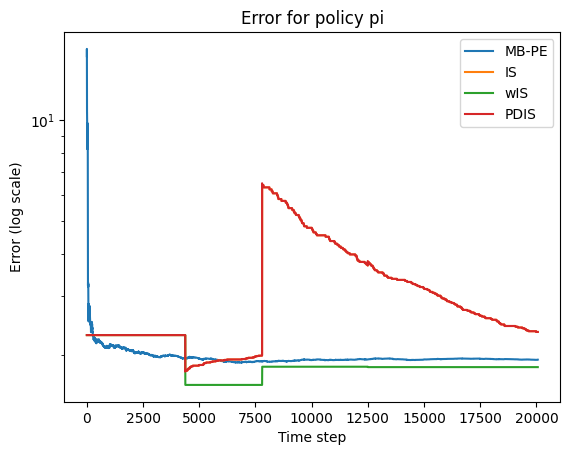

In [30]:

def plot_errors(V_history, V_true, policies, methods, gamma):
    errors = {policy: {method: [] for method in methods} for policy in policies}
    
    for policy in policies:
        for method in methods:
            for V_estimated in V_history[policy][method]:
                error = np.max(np.abs(V_estimated - V_true[policy]))
                errors[policy][method].append(error)
    
    for policy in policies:
        plt.figure()
        for method in methods:
            plt.plot(errors[policy][method], label=method)
        
        plt.yscale('log')
        plt.title(f'Error for policy {policy}')
        plt.xlabel('Time step')
        plt.ylabel('Error (log scale)')
        plt.legend()
        plt.savefig(f'artifacts/errors_{policy}_gamma_{gamma}.png', dpi=300)
        plt.show()
        
def plot_errors_single(V_history, V_true, policies, methods, gamma):
    errors = {policy: {method: [] for method in methods} for policy in policies}
    
    # Calculate the errors
    for policy, methods_values in V_history.items():
        for method, V_estimated_history in methods_values.items():
            for V_estimated in V_estimated_history:
                error = np.max(np.abs(V_estimated - V_true[policy]))
                errors[policy][method].append(error)
    
    # Plot all errors on one plot
    plt.figure(figsize=(10, 8))
    for policy in policies:
        for method in methods:
            plt.plot(errors[policy][method], label=f'{method} ({policy})')
    
    plt.yscale('log')
    plt.title(f'Error for all policies with gamma {gamma}')
    plt.xlabel('Time step')
    plt.ylabel('Error (log scale)')
    plt.legend()
    plt.savefig(f'artifacts/errors_all_policies_gamma_{gamma}.png', dpi=300)
    plt.show()

# Plot the errors
V_history = {
    'pi': {'MB-PE': V_mb_history_pi2, 'IS': V_is_history, 'wIS': V_wis_history, 'PDIS': V_pdis_history}
}
V_true_d = {
    'pi': V_true
}
plot_errors(V_history, V_true_d, ['pi'], ['MB-PE', 'IS', 'wIS', 'PDIS'], 0.95)
# plot_errors_single(V_history, V_true, ['pi1', 'pi2'], ['TD_a1', 'TD_a2', 'MB-PE'], 0.95)